# Comparing Neural Nets on Heart Failure Data Using SVMs and MLPs

This notebook is testing the models. Much of the code is taken from the training notebook as the structure is similar and simple

Summary:

My 2 best models are the Base MLP and the Base SVM. Both models are able to be loaded here. While the AUCs and classification reports are very similar, the best model I am selecting to be is the Base SVM given its simpler set up even though, based on the scores in the classification report, the Base MLP preformed marginally better than the Base SVM. The base versions of the models were randomly initialized with small sized parameters and surprisngly (or luckily) preformed better than the tuned versions. 

Additionally I have included the tuned versions of both models just to serve as a comparison. 

## Installing Packages

In [1]:
#!pip install pandas==2.2.1
#!pip install scipy==1.13.0
#!pip install matplotlib==3.8.4
#!pip install seaborn==0.13.2
#!pip install scikit-learn==1.4.0
#!pip install torch==2.2.2
#!pip install skorch==0.15.0
#!pip install joblib==1.4.0

## Importing Packages

In [2]:
#not all of these are used but were imported for testing at one point or another

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torch.utils.data import WeightedRandomSampler

import skorch
from skorch import NeuralNetClassifier
from skorch.callbacks import EpochScoring
from skorch.callbacks import EarlyStopping
from skorch.callbacks import Checkpoint

import sklearn
from sklearn.feature_selection import chi2
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import auc
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import classification_report
from sklearn.metrics import make_scorer
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_validate
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import RobustScaler

import time

import joblib
from joblib import dump #added to save parameters and models

#adding this as for the countplots my code was working but was a huge error that was not problematic while running with the selected libararies
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

#added so i can easily create a results section at the end of the notebook without having to write the plot code again
from IPython.display import Image

## Setting Up The Code

In [3]:
#loading the test data and making a copy to work on

df = pd.read_csv('final_test_data.csv')
test_df_heart = df.copy()
test_df_heart

Age  RestingBP  Cholesterol  MaxHR  Oldpeak  Sex_M  ChestPainType_ATA  \
0     63        140          187    144        4      1                  0   
1     48        130          245    180        0      1                  1   
2     62        124          209    163        0      0                  0   
3     48        130          275    139        0      0                  0   
4     37        140          207    130        1      1                  0   
..   ...        ...          ...    ...      ...    ...                ...   
107   62        152          153     97        1      1                  0   
108   43        120          291    155        0      1                  0   
109   59        140          287    150        0      1                  1   
110   60        102          318    160        0      0                  0   
111   64        180          325    154        0      0                  0   

     ChestPainType_NAP  ChestPainType_TA  FastingBS_Yes  RestingECG_Normal  \
0                    0                 0              0                  0   
1                    0                 0              0                  0   
2                    0                 0              0                  1   
3                    1                 0              0                  1   
4                    0                 0              0                  1   
..                 ...               ...            ...                ...   
107                  0                 0              0                  0   
108                  0                 1              0                  0   
109                  0                 0              0                  1   
110                  1                 0              0                  1   
111                  0                 0              0                  1   

     RestingECG_ST  ExerciseAngina_Y  ST_Slope_Flat  ST_Slope_Up  HeartDisease  
0                0                 1              0            1           1.0  
1                0                 0              1            0           0.0  
2                0                 0              0            1           0.0  
3                0                 0              0            1           0.0  
4                0                 1              1            0           1.0  
..             ...               ...            ...          ...           ...  
107              1                 1              0            1           1.0  
108              1                 0              1            0           1.0  
109              0                 0              0            1           0.0  
110              0                 0              0            1           0.0  
111              0                 1              0            1           0.0  

[112 rows x 16 columns]

In [4]:
#loading the saved scaling parameters we got from training
#these parameters will be used to scale our test data

scaler_loaded = joblib.load('robust_scaled_train_data_parameters.joblib')

In [5]:
#scaling and preparing X and y

X_scaling = test_df_heart.iloc[:, :-1]
X = scaler_loaded.transform(X_scaling)
X = pd.DataFrame(X, columns=X_scaling.columns, index=X_scaling.index)

y = test_df_heart.iloc[:, -1:]

In [6]:
#further adjustments to X and y

X = X.astype('float32')
y = y.astype('float32')

X_np = X.to_numpy()
y_np = y.to_numpy()

y_np_ravel = y_np.ravel()

In [7]:
#one of the models used a custom class
#couldnt be loaded directly from the pickle
#need an instance here for it to then work with the pickle file

class Base_Binary_Classifier_MLP(nn.Module):
    def __init__(self, mlp_base_input_size, mlp_base_hidden_layer_size):
        super(Base_Binary_Classifier_MLP, self).__init__()
        self.layer1 = nn.Linear(mlp_base_input_size, 
                                mlp_base_hidden_layer_size) #this is the input layer using 'inputs' | also the single hidden layer using ReLU
        self.relu = nn.ReLU()
        self.layer2 = nn.Linear(mlp_base_hidden_layer_size, 1) #this is the output layer that is then passed to the sigmoid to scale values to 0 or 1

    def forward(self, x):
        x = self.layer1(x)
        x = self.relu(x)
        x = self.layer2(x)
        x = torch.sigmoid(x)
        return x

In [8]:
#one of the models used a custom class
#couldnt be loaded directly from the pickle
#need an instance here for it to then work with the pickle file

class Final_Tuned_Binary_Classifier_MLP(nn.Module):
    def __init__(self, final_mlp_tuned_input_size, final_mlp_tuned_hidden_layers, final_mlp_tuned_hidden_layer_size,
                 final_mlp_tuned_output_size, final_mlp_tuned_dropout_rate, final_mlp_tuned_activation_function):
        super(Final_Tuned_Binary_Classifier_MLP, self).__init__()
        self.layers = nn.ModuleList()
        self.layers.append(nn.Linear(final_mlp_tuned_input_size, final_mlp_tuned_hidden_layer_size))
        self.layers.append(final_mlp_tuned_activation_function())
        self.layers.append(nn.Dropout(final_mlp_tuned_dropout_rate))
        
        for _ in range(1, final_mlp_tuned_hidden_layers):
            self.layers.append(nn.Linear(final_mlp_tuned_hidden_layer_size, final_mlp_tuned_hidden_layer_size))
            self.layers.append(final_mlp_tuned_activation_function())
            self.layers.append(nn.Dropout(final_mlp_tuned_dropout_rate))
        
        self.layers.append(nn.Linear(final_mlp_tuned_hidden_layer_size, final_mlp_tuned_output_size))
        self.layers.append(nn.Sigmoid())

    def forward(self, x):
        for layer in self.layers:
            x = layer(x)
        return x

In [9]:
#loading up the trained models

base_mlp_net = joblib.load('base_mlp_net.pkl')
final_tuned_mlp_net = joblib.load('final_tuned_mlp_net.pkl')
base_svm = joblib.load('base_svm.pkl')
final_tuned_svm = joblib.load('final_tuned_svm.pkl')

In [10]:
#predicting on the test data

final_test_predections_base_mlp_net = base_mlp_net.predict(X_np)
final_test_predections_final_tuned_mlp_net = final_tuned_mlp_net.predict(X_np)
final_test_predections_base_svm = base_svm.predict(X_np)
final_test_predections_final_tuned_svm = final_tuned_svm.predict(X_np)

In [11]:
#creating the classification reports

final_test_classification_report_base_mlp_net = classification_report(y_np_ravel, final_test_predections_base_mlp_net)
final_test_classification_report_final_tuned_mlp_net = classification_report(y_np_ravel, final_test_predections_final_tuned_mlp_net)
final_test_classification_report_base_svm = classification_report(y_np_ravel, final_test_predections_base_svm)
final_test_classification_report_final_tuned_svm = classification_report(y_np_ravel, final_test_predections_final_tuned_svm)

In [12]:
#creating the confusion matricies

final_test_confusion_matrix_base_mlp = confusion_matrix(y_np_ravel, final_test_predections_base_mlp_net)
final_test_confusion_matrix_final_tuned_mlp = confusion_matrix(y_np_ravel, final_test_predections_final_tuned_mlp_net)
final_test_confusion_matrix_base_svm = confusion_matrix(y_np_ravel, final_test_predections_base_svm)
final_test_confusion_matrix_final_tuned_svm = confusion_matrix(y_np_ravel, final_test_predections_final_tuned_svm)

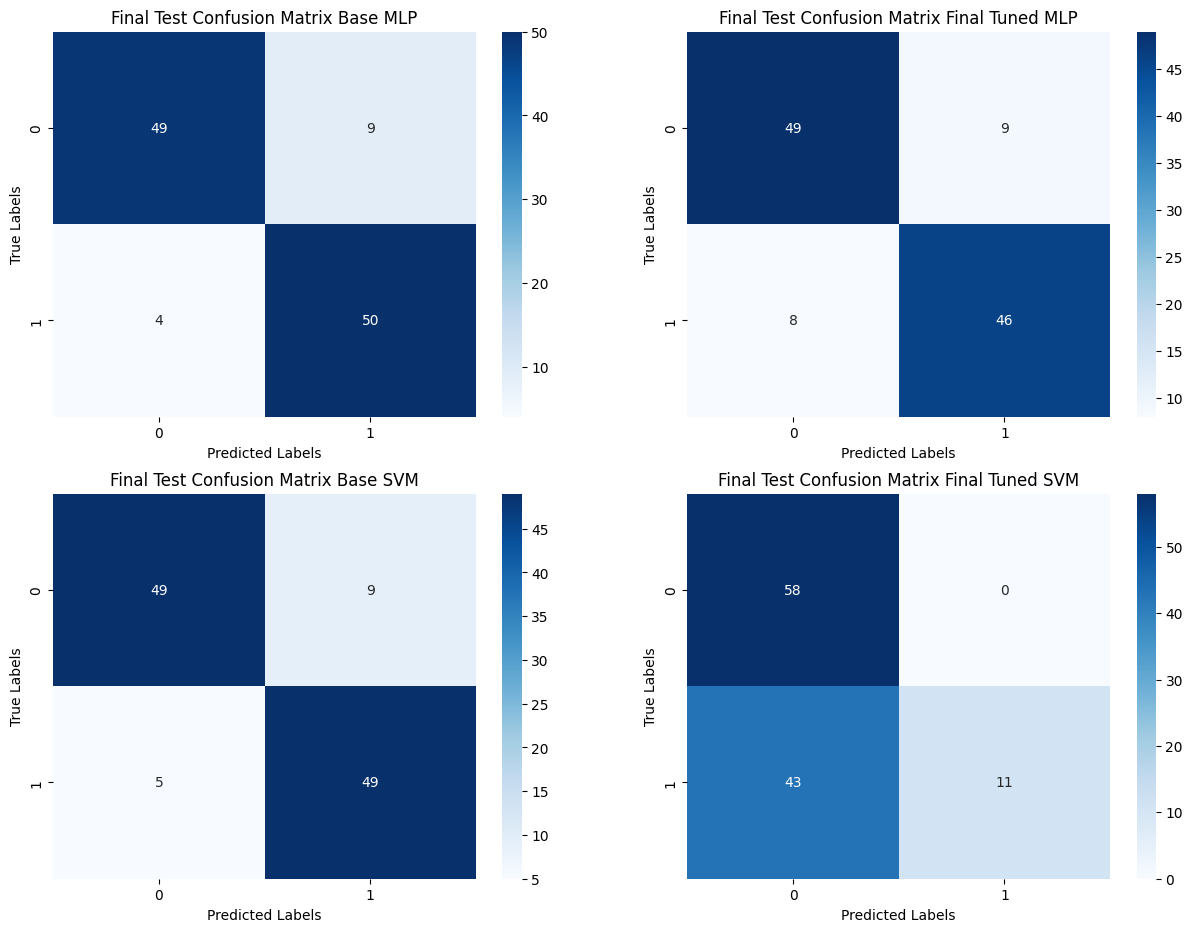

In [13]:
#plotting all the ROC curves in the same plot - can view it here or just in the results section

plt.figure(figsize=(15, 11))

#base mlp
plt.subplot(2, 2, 1)
sns.heatmap(final_test_confusion_matrix_base_mlp, annot=True, fmt='d', cmap='Blues', cbar=True)
plt.title('Final Test Confusion Matrix Base MLP')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')

#final tuned mlp
plt.subplot(2, 2, 2)
sns.heatmap(final_test_confusion_matrix_final_tuned_mlp, annot=True, fmt='d', cmap='Blues', cbar=True)
plt.title('Final Test Confusion Matrix Final Tuned MLP')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')

#base svm
plt.subplot(2, 2, 3)
sns.heatmap(final_test_confusion_matrix_base_svm, annot=True, fmt='d', cmap='Blues', cbar=True)
plt.title('Final Test Confusion Matrix Base SVM')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')

#final tuned svm
plt.subplot(2, 2, 4)
sns.heatmap(final_test_confusion_matrix_final_tuned_svm, annot=True, fmt='d', cmap='Blues', cbar=True)
plt.title('Final Test Confusion Matrix Final Tuned SVM')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')

plt.savefig('final_test_confusion_matricies.png')

#plt.show()

In [14]:
#getting the probabilites rather than straight predictions to calculate the AUC

final_test_probabilities_base_mlp = base_mlp_net.predict_proba(X_np)
final_test_probabilities_final_tuned_mlp = final_tuned_mlp_net.predict_proba(X_np)
final_test_probabilities_base_svm = base_svm.predict_proba(X_np)
final_test_probabilities_final_tuned_svm = final_tuned_svm.predict_proba(X_np)

In [15]:
#adjusting the arrays

final_test_probabilities_base_mlp = np.squeeze(final_test_probabilities_base_mlp)
final_test_probabilities_final_tuned_mlp = np.squeeze(final_test_probabilities_final_tuned_mlp)
final_test_probabilities_base_svm = np.squeeze(final_test_probabilities_base_svm)
final_test_probabilities_final_tuned_svm = np.squeeze(final_test_probabilities_final_tuned_svm)

In [16]:
#more adjustments

final_test_probabilities_base_mlp = final_test_probabilities_base_mlp[:, 1]
final_test_probabilities_final_tuned_mlp = final_test_probabilities_final_tuned_mlp[:, 1]
final_test_probabilities_base_svm = final_test_probabilities_base_svm[:, 1]
final_test_probabilities_final_tuned_svm = final_test_probabilities_final_tuned_svm[:, 1]

In [17]:
#applying roc_curve

final_test_fpr_base_mlp, final_test_tpr_base_mlp, _ = roc_curve(y_np_ravel, final_test_probabilities_base_mlp)
final_test_fpr_final_tuned_mlp, final_test_tpr_final_tuned_mlp, _ = roc_curve(y_np_ravel, final_test_probabilities_final_tuned_mlp)
final_test_fpr_base_svm, final_test_tpr_base_svm, _ = roc_curve(y_np_ravel, final_test_probabilities_base_svm)
final_test_fpr_final_tuned_svm, final_test_tpr_final_tuned_svm, _ = roc_curve(y_np_ravel, final_test_probabilities_final_tuned_svm)

In [18]:
#applying the auc function

final_test_auc_base_mlp = auc(final_test_fpr_base_mlp, final_test_tpr_base_mlp)
final_test_auc_final_tuned_mlp = auc(final_test_fpr_final_tuned_mlp, final_test_tpr_final_tuned_mlp)
final_test_auc_base_svm = auc(final_test_fpr_base_svm, final_test_tpr_base_svm)
final_test_auc_final_tuned_svm = auc(final_test_fpr_final_tuned_svm, final_test_tpr_final_tuned_svm)

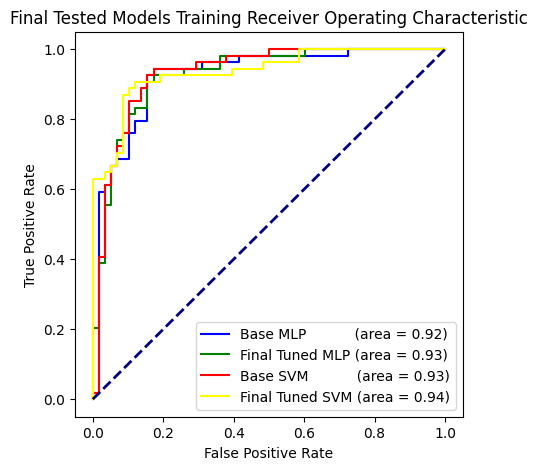

In [19]:
#plotting the roc curves - can view here or in results

plt.figure(figsize=(5, 5))
plt.plot(final_test_fpr_base_mlp, final_test_tpr_base_mlp, color='blue', 
         lw=1.5, label=f'Base MLP           (area = {final_test_auc_base_mlp:.2f})')
plt.plot(final_test_fpr_final_tuned_mlp, final_test_tpr_final_tuned_mlp, color='green',
         lw=1.5, label=f'Final Tuned MLP (area = {final_test_auc_final_tuned_mlp:.2f})')
plt.plot(final_test_fpr_base_svm, final_test_tpr_base_svm, color='red',
         lw=1.5, label=f'Base SVM           (area = {final_test_auc_base_svm:.2f})')
plt.plot(final_test_fpr_final_tuned_svm, final_test_tpr_final_tuned_svm, color='yellow',
         lw=1.5, label=f'Final Tuned SVM (area = {final_test_auc_final_tuned_svm:.2f})')

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Final Tested Models Training Receiver Operating Characteristic')
plt.legend(loc="lower right")

plt.savefig('final_test_roc_curves.png')

#plt.show()

## Results

In [20]:
print('Test Classification Report Base MLP:')
print(final_test_classification_report_base_mlp_net)
print('--------------------')
print('Test Classification Report Final Tuned MLP:')
print(final_test_classification_report_final_tuned_mlp_net)
print('--------------------')
print('Test Classification Report Base SVM:')
print(final_test_classification_report_base_svm)
print('--------------------')
print('Test Classification Report Final Tuned SVM:')
print(final_test_classification_report_final_tuned_svm)

Test Classification Report Base MLP:
              precision    recall  f1-score   support

         0.0       0.92      0.84      0.88        58
         1.0       0.85      0.93      0.88        54

    accuracy                           0.88       112
   macro avg       0.89      0.89      0.88       112
weighted avg       0.89      0.88      0.88       112

--------------------
Test Classification Report Final Tuned MLP:
              precision    recall  f1-score   support

         0.0       0.86      0.84      0.85        58
         1.0       0.84      0.85      0.84        54

    accuracy                           0.85       112
   macro avg       0.85      0.85      0.85       112
weighted avg       0.85      0.85      0.85       112

--------------------
Test Classification Report Base SVM:
              precision    recall  f1-score   support

         0.0       0.91      0.84      0.88        58
         1.0       0.84      0.91      0.88        54

    accuracy          

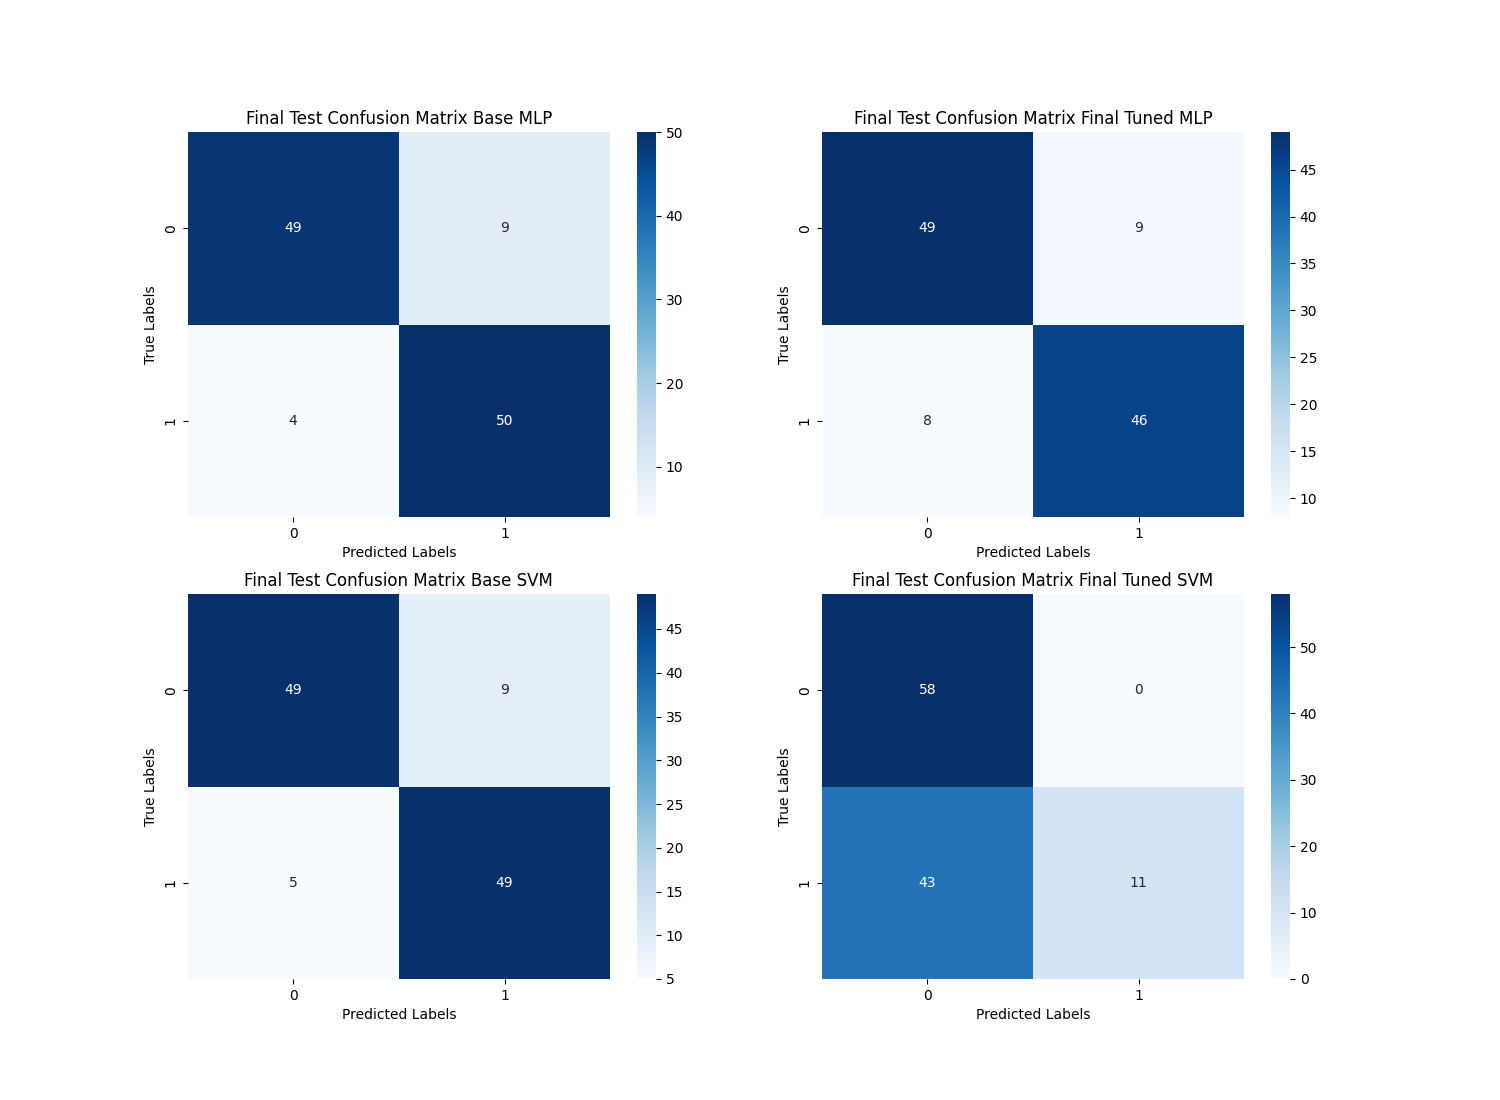

In [21]:
Image(filename='final_test_confusion_matricies.png')

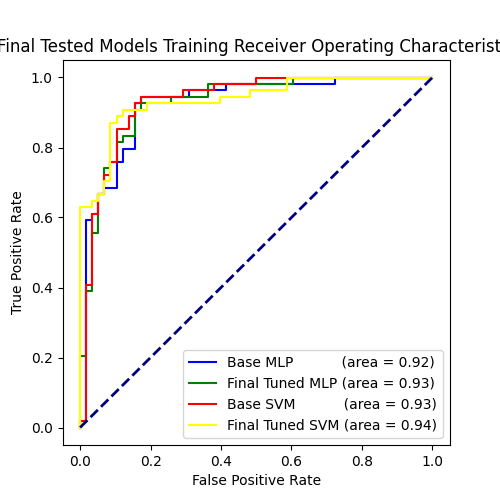

In [22]:
Image(filename='final_test_roc_curves.png')